# UDM2

## Install Dependencies and Set up Notebook

In [1]:
import os

## Define UDM2

The UDM2 asset is available for the `PSScene4Band` item-type. Not all PSScene4Band scenes have a UDM2 asset, so here we define the scene and item-type for the UDM2 asset.

In [31]:
scene_id = '20190321_174348_0f1a'
item_type = 'PSScene4Band'

## Search  UDM2

In [37]:
# uncomment to see metadata fields
# !planet data search --item-type $item_type --string-in id $scene_id

Someday, fields will be added to the item `properties` that will allow for filtering on UDM2 values. Examples are `clear_percent` and `cloud_percent`. See the [WIP UDM2 documentation](http://planet-developer-center-website.s3-website-us-west-2.amazonaws.com/6d1845612d76a722f1e268e40cf88d2ecc6595e3/docs/api/udm-2/) for more fields. These metadata fields aren't yet present, so we will skip search and filtering of the UDM2 for now.

## Download UDM2

To download the udm, we use the planet CLI because it handles activating, waiting for activation, and downloading the file.

We will save the udm in the data folder. This folder isn't tracked by git so the downloaded image file will not bloat our git repository.

In [2]:
# create the data folder if it doesn't exist
data_folder = 'data'
if not os.path.isdir(data_folder): os.mkdir(data_folder)

In [38]:
!planet data download --item-type $item_type \
                      --asset-type udm2 \
                      --string-in id $scene_id \
                      --dest data

activating: 0            complete: 0              elapsed: 0                    
paging: False            pending: 0                                             

activating: 1            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 1               paging: True                  
pending: 0                                                                      

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 2               paging: False                 
pending: 1                                                                      

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 2               paging: False                 
pending: 1                                                                      
2019-04-04 22:35:29,822 - FuturesSession - WARNING - `background_callback` is
deprecated and will be remov

In [39]:
# store the udm filename for processing and make sure the file exists
udm2_filename = os.path.join('data', scene_id + '_cloud_map.tif')
print(udm2_filename)
assert os.path.isfile(udm2_filename)

data/20190321_174348_0f1a_cloud_map.tif


## Load UDM2

In [104]:
# Utility functions for loading a UDM2 image and identify bands as
# class labels
def load_udm2(udm2_filename):
    '''Load multi-band UDM2 as a 3d array.'''
    with rasterio.open(udm2_filename, 'r') as src:
        udm2 = src.read()
    return udm2

udm2_labels = ['clear', 'snow', 'shadow', 'light haze', 'heavy haze', 'cloud',
               'confidence', 'unusable pixels']

udm2 = load_udm2(udm2_filename)
print(udm2.shape)
print(udm2_labels)

(8, 4213, 8341)
['clear', 'snow', 'shadow', 'light haze', 'heavy haze', 'cloud', 'confidence', 'unusable pixels']


In [46]:
100 * (np.size(udm2[0,:]) - np.count_nonzero(udm2[0,:])) / np.size(udm2[0,:])

44.4015450717692

# Visualize UDM2

### Visualizing a Classified Band

In [10]:
from collections import OrderedDict
import os
import subprocess

import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import rasterio

%matplotlib inline

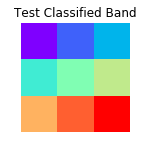

In [47]:
def plot_classified_band_ax(class_band, ax, cmap='rainbow',
                         title='Class Labels', figdim=10):
    fig = plt.figure(figsize=(figdim, figdim))
    ax = fig.add_subplot(1, 1, 1)
    imshow_class_band(ax, class_band, class_labels, cmap=cmap)
    ax.set_title(title)
    ax.set_axis_off()

def imshow_class_band(ax, class_band, class_labels=None, cmap='rainbow'):
    """Show classified band with colormap normalization and color legend. Alters ax in place.
    
    possible cmaps ref: https://matplotlib.org/examples/color/colormaps_reference.html
    """
    class_norm = _ClassNormalize(class_band)
    im = ax.imshow(class_band, cmap=cmap, norm=class_norm)

    try:
        # add class label legend
        # https://stackoverflow.com/questions/25482876
        # /how-to-add-legend-to-imshow-in-matplotlib
        color_mapping = class_norm.mapping
        colors = [im.cmap(color_mapping[k]) for k in class_labels.keys()]
        labels = class_labels.values()

        # https://matplotlib.org/users/legend_guide.html
        # tag: #creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
        patches = [mpatches.Patch(color=c, label=l) for c,l in zip(colors, labels)]

        ax.legend(handles=patches, bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.)
    except AttributeError:
        # class_labels not specified
        pass

# Inspired by
# https://matplotlib.org/users/colormapnorms.html#custom-normalization-two-linear-ranges
class _ClassNormalize(colors.Normalize):
    """Matplotlib colormap normalizer for a classified band.
    """
    def __init__(self, arry):
        # get unique unmasked values
        values = [v for v in np.unique(arry)
                  if not isinstance(v, np.ma.core.MaskedConstant)]

        # map unique values to points in the range 0-1
        color_ticks = np.array(range(len(values)), dtype=np.float) / (len(values) - 1)
        self._mapping = dict((v, ct) for v, ct in zip(values, color_ticks))
        
        # Initialize base Normalize instance
        vmin = 0
        vmax = 1
        clip = False
        colors.Normalize.__init__(self, vmin, vmax, clip)
    
    def __call__(self, arry, clip=None):
        '''Create classified representation of arry for display.'''
        # round array back to ints for logical comparison
        arry = np.around(arry)
        new_arry = arry.copy()
        for k, v in self._mapping.items():
            new_arry[arry==k] = v
        return new_arry
    
    @property
    def mapping(self):
        '''property required for colors.Normalize classes
        
        We update the _mapping property in __init__ and __call__ and just
        return that property here.
        '''
        return self._mapping
    
# test out classified band visualization
test_classified_band = np.array(range(9)).reshape((3,3))
plot_classified_band(test_classified_band, title='Test Classified Band', figdim=2)

### Visualize UDM2 Bands

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


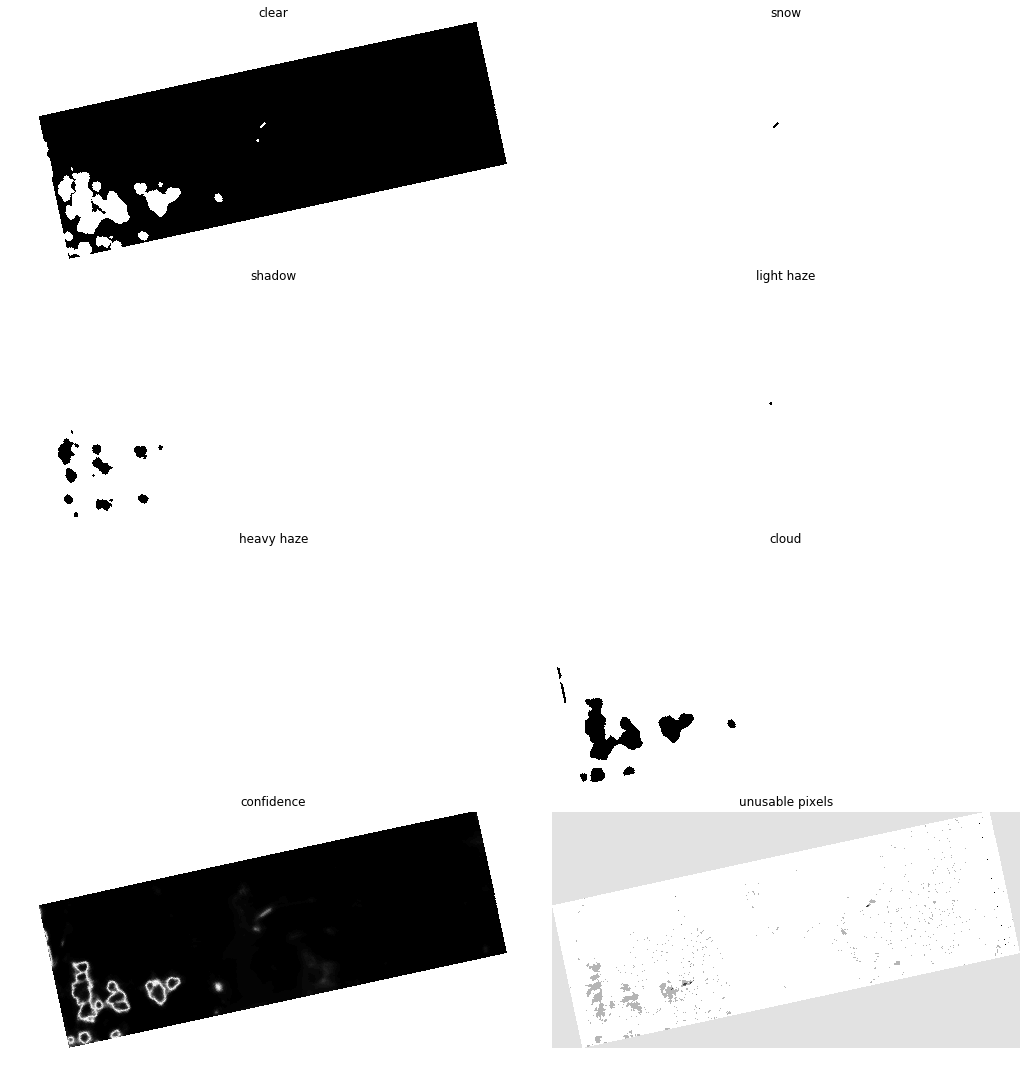

In [106]:
def visualize_udm2(udm2, figsize=(15,15)):
    fig, axes = plt.subplots(nrows=4, ncols=2,
                                   sharex=True, sharey=True,
                                   figsize=figsize)
    
    bands = [np.squeeze(b) for b in 
             np.split(udm2, udm2.shape[0], axis=0)]
    band_labels = udm2_labels

    for i, (band, ax, label) in enumerate(zip(bands, axes.flat, udm2_labels)):        
        imshow_class_band(ax, band, class_labels=None, cmap='Greys')
        ax.set_title(label)
        ax.set_axis_off()

    plt.tight_layout()

visualize_udm2(udm2)

In [ ]:
udm2_udm = udm2[-1,:]
print(udm2_udm.shape)

In [137]:
def get_udm_labels(udm):
    '''Get the interpretation of the UDM binary values'''    
    def get_label(v):
        if v == 0:
            label = 'clear'
        elif v == 1:
            label = 'blackfill'
        else:
            labels = []# ['{0:08b}'.format(v)]
            if v & int('10',2):
                labels.append('cloud')
            if v & int('1111100',2):
                bands = []
                if v & int('100',2):
                    bands.append('Blue')
                if v & int('1000', 2):
                    bands.append('Green')
                if v & int('10000', 2):
                    bands.append('Red')
                if v & int('100000', 2):
                    bands.append('Red-Edge')
                if v & int('1000000', 2):
                    bands.append('NIR')
                labels.append('missing/suspect {} data'.format(', '.join(bands)))
                
            
            if not len(labels):
                labels.append('{0:08b}'.format(v))

            label = ', '.join(labels)
        return label

    return OrderedDict((v, get_label(v)) for v in np.unique(udm))

get_udm_labels(udm2_udm)

OrderedDict([(0, 'clear'),
             (1, 'blackfill'),
             (2, 'cloud'),
             (28, 'missing/suspect Blue, Green, Red data'),
             (30, 'cloud, missing/suspect Blue, Green, Red data'),
             (64, 'missing/suspect NIR data')])

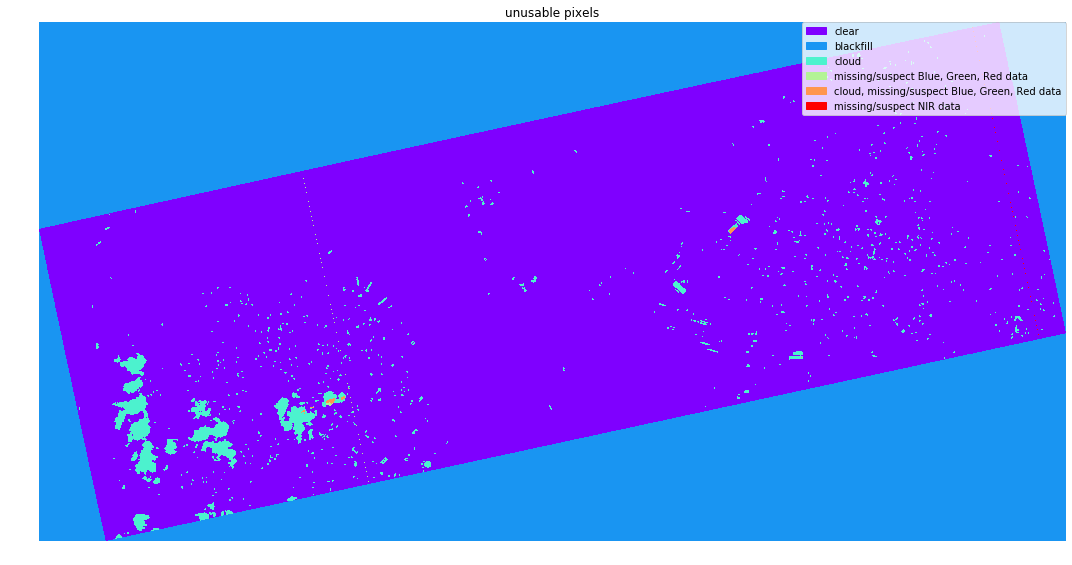

In [138]:
def visualize_udm2_unusable(udm2, figsize=(15,15)):
    fig, ax = plt.subplots(nrows=1, ncols=1,
                                   sharex=True, sharey=True,
                                   figsize=figsize)
    band = udm2[-1, :]
    label = udm2_labels[-1]

    imshow_class_band(ax, band, class_labels=get_udm_labels(band), cmap='rainbow')
    ax.set_title(label)
    ax.set_axis_off()

    plt.tight_layout()

visualize_udm2_unusable(udm2)